# 1-Importamos Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# 2-Cargamos los datos csv locales descargados de Kaggle

In [2]:
df_train = pd.read_csv('Dataset/train.csv')
df_test = pd.read_csv('Dataset/test.csv')
df_Sample_Subm = pd.read_csv('Dataset/sample_submission.csv')

In [3]:
print (df_train.shape, df_test.shape, df_Sample_Subm.shape) 

(7613, 5) (3263, 4) (3263, 2)


In [4]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
df_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [6]:
df_Sample_Subm.head(10)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


# 3-Preparación de los Datos (Data Cleaning)

In [8]:
import re  #Librería de Python para usar expresiones regulares. 

In [9]:
def new_line(text):
    text = re.sub(r'\t', ' ', text) # Ekiminamos tabs. 
    text = re.sub(r'\n', ' ', text) # Eliminamos los "enters".
    return text

In [10]:
def url(text): #Función que utilizamos el clean(text)
    #Eliminamos varios twetts que estan truncados como "Experts in France begin examining airplane debris found on Reunion Island: French air 
        #accident experts o... http://t.co/YVVPznZmXg #news".
    text = re.sub(r' \w{1,3}\.{3,3} http\S{0,}', ' ', text)
    text = re.sub(r' \w{1,3}Û_ http\S{0,}', ' ', text)
    #Algunas palabras (como via) o simbolos antes de 'htttp' son eliminados, asumimos que estas palabras/simbolos no tienen un
    #significado semantico y no influyen en su posicion. 
    text = re.sub(r"mp3 http\S{0,}", r" ", text)
    text = re.sub(r"rar http\S{0,}", r" ", text)
    pattern = re.compile(r'( pin\:\d+ | via )http\S{0,}')
    text = pattern.sub(r' ', text)
    #Eliminamos otros patrones que no tinen gran significado en los tweets: 
    pattern = re.compile(r'Full read by|Full read b|Full read|Full rea|Full re|Full r')
    text = pattern.sub(r' ', text)
    pattern = re.compile(r'Full story at|Full story a|Full story|Full stor|Full sto|Full st|Full s')
    text = pattern.sub(r' ', text)
    
    return text

In [11]:
def clean(text):    
    text = new_line(text)                              # Eliminamos tabs y enters. 
    text = re.sub(r'(&amp;|&gt;|&lt;)', " ", text)     # Eliminamos algunos patrones.
    text = re.sub(r"\s+", " ", text)                   # Eliminamos espacios extras.
    text = url(text)                                   # Eliminamos las urls y algunos patrones.
    
    # Eliminamos los patrones " 'translated' as 'USER' " y " 'traslated' as "USER_NAME" y múltiples "USER":
        #https://www.kaggle.com/quentinsarrazin/tweets-preprocessing   #Idea sacada de este Notebook.
        #https://arxiv.org/ftp/arxiv/papers/1807/1807.07752.pdf        #Paper donde hicieron esto y obtuvieron mejores resultados.
    text = re.sub(r'@\S{0,}', ' USER ', text)
    text = re.sub(r"\s+", " ", text) # Eliminamos espacios extra.   
    text = re.sub(r'\b(USER)( \1\b)+', r'\1', text)
    
    #Hay multiples "letras" que se repiten como "ooooohhhh", y las truncamos a 2 letras. NO hacemos un truncate de 1 letra
    #ya que podría generar falsos significados: por ej. si truncamos 'good' nos diría 'god':
    text = re.sub(r'([a-zA-Z])\1{1,}', r'\1\1', text)
    
    #  Eliminamos URLs si no fueron todavía eliminadas por la función URL: 
    text = re.sub(r"htt\S{0,}", " ", text)
    
    #Removemos todos los caracteres que NO esten en la lista [a-zA-Z\d\s]
    text = re.sub(r"[^a-zA-Z\d\s]", " ", text)
    
    # Hacemos lo mismo que los patrones 'traslated as USER' pero ahora para digitos: " 'translated' to 'NUMBER' " y múltiples "NUMBER NUMBER... to NUMBER":
    text = re.sub(r'^\d\S{0,}| \d\S{0,}| \d\S{0,}$', ' NUMBER ', text)
    text = re.sub(r"\s+", " ", text) # Eliminamos espacios extra. 
    text = re.sub(r'\b(NUMBER)( \1\b)+', r'\1', text)
    
    # Removemos digitos que NO fueron eliminados arriba en 'NUMBER translation'
    text = re.sub(r"[0-9]", " ", text)
    
    text = text.strip()                          # Eliminamos espacios al principio y al fin del string.
    text = re.sub(r' via\s{1,}USER$', ' ', text) # Eliminamos los ' via USER'.
    
    text = re.sub(r"\s+", " ", text) # Removemos espacios extra. 
    text = text.strip()              # Removemos espacios al principio y al final del string. 
    
    return text

In [12]:
#Aplicamos las funciones a la columna text:
df_train.text = df_train.text.apply(clean)
df_test.text = df_test.text.apply(clean)

In [13]:
max_length_tr = df_train.text.map(len).max()
max_length_te = df_test.text.map(len).max()
max_length = max(max_length_tr, max_length_te)

#Imprimimos el mayor texto de tweet en train y en test:
print("At the stage of text processing:")
print(f"...the size of longest text string in train set is  {max_length_tr}")
print(f"...the size of longest text string in test set is  {max_length_te}")

At the stage of text processing:
...the size of longest text string in train set is  162
...the size of longest text string in test set is  151


In [14]:
# Vamos a cortar los tweets y ahora nuestro MAX posible será (max_length - delta). Delta lo definimos como 25.
#Esto lo hacemos ya que al final del tweet hay menor importancia en los mismos (generalmente dicen 'by user' o alguna 
#página web o algún dato sin relevancia, lo importante está al inicio). 
def cut(max_len, delta, x):
    new_max = max_len - delta
    length = len(x)
    if length <= new_max:
        return x 
    else:
        return x[:(new_max-length)]

delta = 25 
df_train.text = df_train.text.map(lambda x: cut(max_length, delta, x))
df_test.text = df_test.text.map(lambda x: cut(max_length, delta, x))

new_max_length_tr = df_train.text.map(len).max()
new_max_length_te = df_test.text.map(len).max()

#Ahora imprimimos nuevamente y vemos que como máximo tenemos 137:
print("After we cut tails of the longest tweets:")
print(f"...the size of longest text string in train set is  {new_max_length_tr}")
print(f"...the size of longest text string in test set is  {new_max_length_te}")

After we cut tails of the longest tweets:
...the size of longest text string in train set is  137
...the size of longest text string in test set is  137


# 4-Aproximación mediante BERT

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de deep learning desarrollado por Google de código abierto. Es utilizado por muchos investigadores e industrias para para resolver muchas tareas de NLP. 

Ktrain (https://github.com/amaiya/ktrain) es un contenedor (wrapper) ligero para la biblioteca de deeplearning TensorFlow Keras (https://www.tensorflow.org/guide/keras/sequential_model) para ayudar a construir, entrenar e implementar ANN's y otros modelos de ML. Diseñado para hacer que el aprendizaje profundo (deep learning) y la IA sean más accesibles y fáciles de aplicar.

Ktrain proporciona soporte para la aplicación de muchas arquitecturas de aprendizaje profundo pre-entrenadas en el dominio de NLP; y BERT es una de ellas. Para resolver este problema, utilizaremos la implementación del BERT pre-entrenado proporcionado por ktrain y lo afinaremos/tunearemos para clasificar si los tweets del desastre son reales o no.

SOLO estamos interesados en la columna TEXTO y TARGET. Las cuales usaremos para clasificar nuestros Tweets.

## Importamos las librerias para leer el csv de entrenamiento (train.csv)

In [15]:
import tensorflow as tf
print(tf.__version__)

import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split

2.2.0
using Keras version: 2.3.0-tf


Leeremos train.csv y realizaremos una división en la columna 'target' donde definiremos el 20% de los datos como el conjunto de validación (validation set).

In [16]:
#Nuestro train.csv está en el DF 'df_train'
random_seed = 12342
x_train, x_val, y_train, y_val = train_test_split(df_train['text'], df_train['target'], shuffle=True, test_size = 0.2, random_state=random_seed, stratify=df_train['target'])

## Convertimos la data en features para BERT

ktrain proporciona una feature muy interesante que nos permite convertir directamente la data de tipo texto en feautures que el modelo necesita. Todo el preprocesamiento del texto no se necesita hacer manualmente... sino que la libreria se encarga de esto. Luego de leer nuestra data de pandas utilizaremos la funciòn 'text_from_array'.

Esta funciòn lo que harà es descargar el modelo de BERT pre-entrenado y su vocabulario. Y en 'preprocess_mode' especificamos 'bert' ya que de esta manera el texto se preprocesarà de una manera especìfica para BERT.

In [17]:
(x_train_bert,  y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                                         x_test = x_val, y_test=y_val,
                                                                                          class_names= ["0", "1"],
                                                                                          preprocess_mode='bert',
                                                                                          lang = 'en',
                                                                                          maxlen=65, 
                                                                                          max_features=35000)

preprocessing train...
language: en


preprocessing test...
language: en


## Cargamos BERT en un objeto 'learner'

La 1ra funciòn ('text_classifier') carga el modelo pre-entrenado de BERT con una capa Dense final inicializada aleatoriamente. Ya que todas las capas del modelo son entrenables, los pesos de todas las capas del modelo se actualizarán durante el proceso de backpropagation.

La 2da funciòn ('get_learner') crea un objeto 'learner' con data de entrenamiento y data de validaciòn que son usados para "afinar" el clasificador. EL ùltimo paràmetro de 'get_learner' es el "batch size" (usamos un batch size pequeño, de 16).

In [18]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert), batch_size=16)

Is Multi-Label? False
maxlen is 65
done.


## ENTRENAMIENTO ("tuneando" el Clasificador BERT)

Para entrenar el modelo, 1ro buscaremos el learning rate òptimo que funcione para nuestro problema. Ktrain provee un mètodo 'lr_find' que nos permite entrenar al modelo con diferentes learning rates y plotear el loss del modelo a medida que el LR incrementa

In [19]:
learner.lr_find()    #SImulamos un entrenamiento para encontrar el mejor LR.

simulating training for different learning rates... this may take a few moments...
Train on 6090 samples
Epoch 1/1024
6090/6090 [==============================] - 141s 23ms/sample - loss: 0.8705 - acc: 0.5182
Epoch 2/1024
6090/6090 [==============================] - 142s 23ms/sample - loss: 0.4585 - acc: 0.7970
Epoch 3/1024
6090/6090 [==============================] - 143s 23ms/sample - loss: 0.7433 - acc: 0.5795
Epoch 4/1024
1376/6090 [=====>........................] - 32s 23ms/sample - loss: 1.5896 - acc: 0.5116


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


### Ploteamos el learning rate:

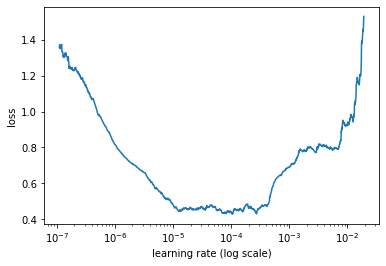

In [20]:
#Para observar el plot del LR:
learner.lr_plot()

Podemos observar que el clasificador provee un loss mìnimo cuando el LR es 1e-5. ENtonces, usamos este LR para entrenar el modelo mediante el mètodo 'autofit'. Este mètodo entrena el clasificador y automàticamente selecciona la mejor performance del modelo previniendo el underfitting y overfitting del mismo.

In [21]:
learner.autofit(1e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-05...
Train on 6090 samples, validate on 1523 samples
Epoch 1/1024
6090/6090 [==============================] - 156s 26ms/sample - loss: 0.5273 - acc: 0.7424 - val_loss: 0.3746 - val_acc: 0.8431
Epoch 2/1024
6090/6090 [==============================] - 156s 26ms/sample - loss: 0.3576 - acc: 0.8552 - val_loss: 0.3653 - val_acc: 0.8523
Epoch 3/1024
6090/6090 [==============================] - 156s 26ms/sample - loss: 0.2977 - acc: 0.8869 - val_loss: 0.3806 - val_acc: 0.8391
Epoch 4/1024
6090/6090 [==============================] - ETA: 0s - loss: 0.2351 - acc: 0.9112
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 5e-06 (if not early_stopping).
6090/6090 [==============================] - 156s 26ms/sample - loss: 0.2351 - acc: 0.9112 - val_loss: 0.4632 - val_acc: 0.8345
Epoch 5/1024
6090/6090 [=======

In [22]:
learner.validate(val_data=(x_val_bert, y_val_bert), class_names=['No Disaster', 'Disaster'])

              precision    recall  f1-score   support

 No Disaster       0.84      0.92      0.88       869
    Disaster       0.88      0.76      0.82       654

    accuracy                           0.85      1523
   macro avg       0.86      0.84      0.85      1523
weighted avg       0.85      0.85      0.85      1523



array([[802,  67],
       [158, 496]])

Vemos que tenemos buenos f1-score para cada clase predicha.
Luego de entrenar nuestro modelo con el mètodo 'autofit', ahora es tiempo de realizar predicciones sobre la data de TEST.


## Obtenemos la variable predictora

La variable predictora es obtenida pasandole el modelo y el objeto 'preproc' al mètodo 'get_predictor'. Este 'predictor' puede ser usado para realizar predicciones en nuestra data de TEST directamente.

In [23]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
learner.print_layers()  #Para observar todas las capas del modelo. 

In [24]:
#Guardamos nuestro modelo y sus pesos para su futuro uso:
learner.model.save_weights("model-bert-more-cleaning.h5")
print("Saved model to disk")

Saved model to disk


## 5-Predecimos en el CSV de TEST

In [25]:
df_test["target"] = predictor.predict(df_test["text"].tolist())
df_test = df_test[["id", "target"]]
df_test.to_csv("submission_bert_more_cleaned.csv", index=False)